# Описание проекта

Подготовка прототипа машинного обучения для компании, разрабатывающей решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

In [1]:
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt

import re
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# 1. Подготовка данных

## 1.1 Изучение файлов

Загрузим исходные файлы в соответствующие датафреймы.

In [2]:
df_train = pd.read_csv('/datasets/gold_recovery_train.csv')
df_test = pd.read_csv('/datasets/gold_recovery_test.csv')
df_full = pd.read_csv('/datasets/gold_recovery_full.csv')

Посмотрим что представляет из себя первая таблица.

In [3]:
df_train

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16855,2018-08-18 06:59:59,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,...,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
16856,2018-08-18 07:59:59,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,...,22.960095,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608
16857,2018-08-18 08:59:59,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452
16858,2018-08-18 09:59:59,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471


Таблица содержит 16860 объектов и 87 признаков, разбитых по этапам обработки. Посмотрим информацию о таблице.

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

В таблице имеются пропущенные значения. Их можно заменить смежными значениями (покольку в условиях указано, что соседние по времени параметры часто похожи).

Посмотрим на остальные таблицы.

In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

In [6]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

Судя по объектам и признакам, таблица full составлена из первых двух таблиц. Причем, судя по количеству пропусков в признаках final, в ней присутствуют целевые признаки для тестовой выборки.

Заменим пропущенные значения в таблицах. Поскольку в условии указано, что близкие по времени параметры схожи по значению, заменим пропущенные значения на предыдущие.

In [7]:
df_train.fillna(method='ffill', inplace=True)
df_test.fillna(method='ffill', inplace=True)
df_full.fillna(method='ffill', inplace=True)

## 1.2 Проверка правильности расчета эффективности обогащения

Эффективность обогащения рассчитывается по формуле:
$$Recovery= \frac {C*(F-T)}{F*(C-T)}*100$$
где:
C — доля золота в концентрате после флотации/очистки;
F — доля золота в сырье/концентрате до флотации/очистки;
T — доля золота в отвальных хвостах после флотации/очистки.

Напишем функцию для вычисления recovery. При F равном нулю чтобы избежать ошибки деления на ноль подставим в качестве результирующего значения 0. Также сразу в функции заменим выходящие за границы допустимых значений (0-100) эффективности и положим их на границы.

In [8]:
def recovery_eff(row):
    c = row['rougher.output.concentrate_au']
    f = row['rougher.input.feed_au']
    t = row['rougher.output.tail_au']
    try:
        recovery = (c * (f - t)) / (f * (c - t)) * 100
        if recovery < 0:
            return 0
        elif recovery > 100:
            return 100
        return recovery
    except: 
        return 0

Применим функцию к обучающей выборке.

In [9]:
recovery_efficiency = df_train.apply(recovery_eff, axis=1)

Найдем MAE между вашими расчётами и значением признака rougher.output.recovery.

In [10]:
mae = mean_absolute_error(df_train['rougher.output.recovery'], recovery_efficiency)
mae

6.191509865082802

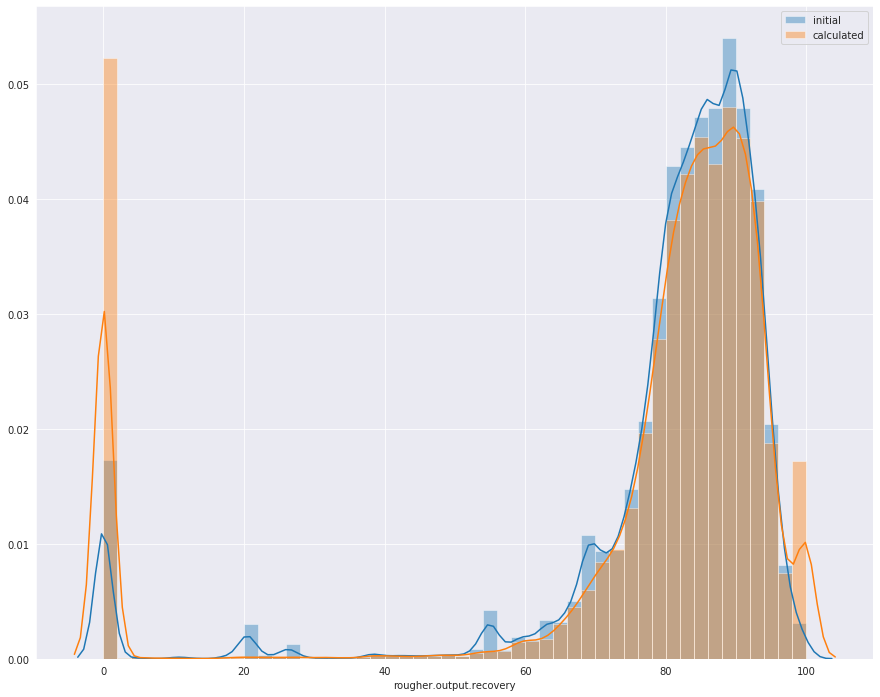

In [11]:
plt.figure(figsize=(15, 12))
ax= sns.distplot(df_train['rougher.output.recovery'], label='initial')
sns.distplot(recovery_efficiency, label='calculated')
ax.legend();

Абсолютное отклонение между исходными значениями и нашим расчетами небольшое, причем в наших расчетах чаще всречаются нулевые значения. В качестве показателей эффективности будем использовать исходный целевой признак. Отбросим нулевые значения.

In [12]:
df_train = df_train[(df_train['rougher.output.recovery']>0)]

In [13]:
df_train.shape

(16284, 87)

Потеряли около 15% данных. Неприятно, но приемлемо. Зато оценка эффективности будет более точной.

## 1.3 Анализ признаков, недоступных в тестовой выборке

In [14]:
train_columns = df_train.columns
test_columns = df_test.columns
lost_features = train_columns.difference(test_columns)

In [15]:
lost_features

Index(['final.output.concentrate_ag', 'final.output.concentrate_au',
       'final.output.concentrate_pb', 'final.output.concentrate_sol',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au',
       'final.output.tail_pb', 'final.output.tail_sol',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au',
       'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
       'rougher.calculation.au_pb_ratio',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_au',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'roughe

В тестовой выборке отсутствуют выходные показатели сырья, а также показатели, рассчитанные на их основе (отношение au-pb при флотации). Эти признаки относятся к целевым признакам.

## 1.4 Предобработка данных

Для возможности делать корректные срезы по трем таблицам заменим индексы у них на столбец date.

In [16]:
df_train.index = df_train['date']
df_test.index = df_test['date']
df_full.index = df_full['date']

# 2. Анализ данных

## 2.1 Изменение концентрации металлов на различных этапах очистки

Напишем функцию для построения распределений концентраций металлов.

In [17]:
def conc_change(feed, rougher, primary_cleaner, secondary_cleaner, metal):
    plt.figure(figsize=(17, 10))
    ax=sns.distplot(feed, label='Подача')
    sns.distplot(rougher, label='Флотация')
    sns.distplot(primary_cleaner, label='Первичная очистка')
    sns.distplot(secondary_cleaner, label='Вторичная очистка')
    plt.title(metal, fontsize=17)
    plt.xlabel('Концентрация, %', fontsize=15)
    ax.legend()

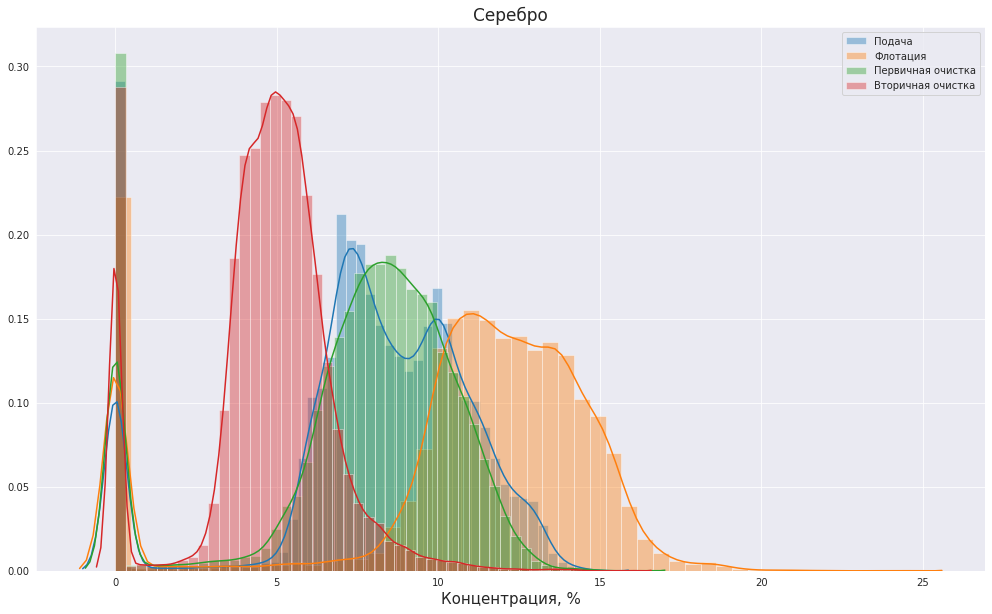

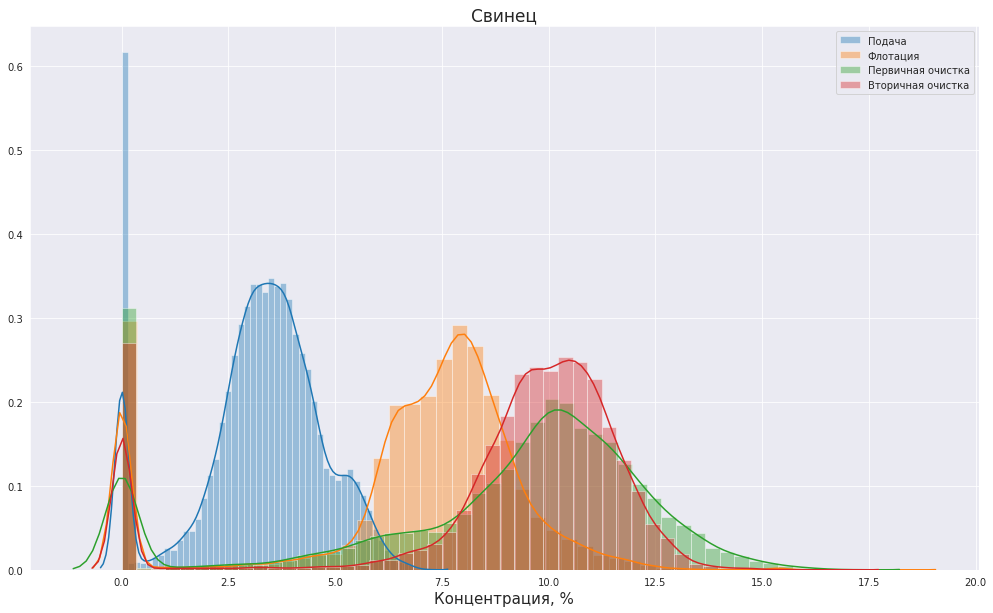

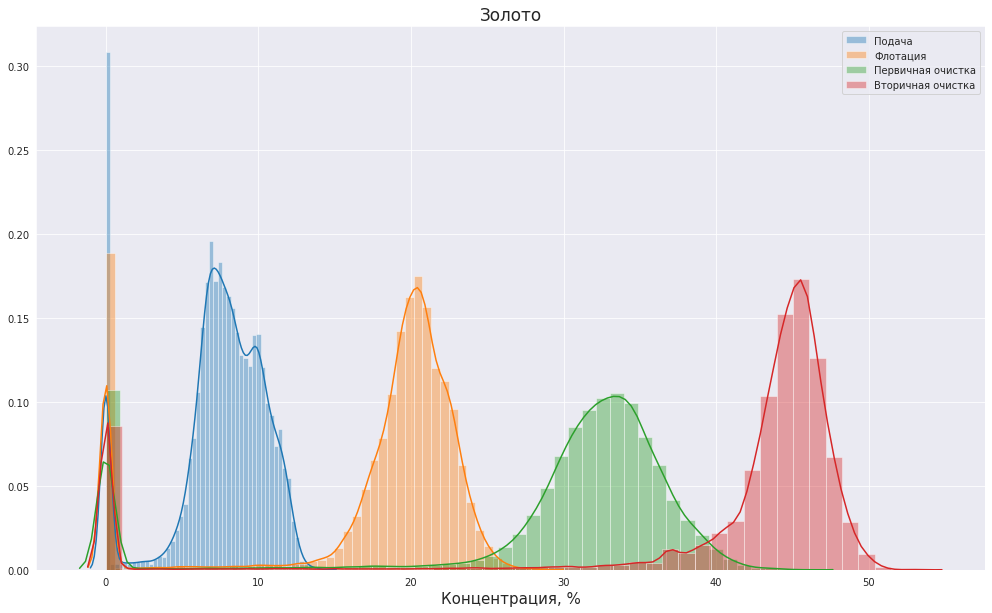

In [18]:
conc_change(df_full['rougher.input.feed_ag'],
            df_full['rougher.output.concentrate_ag'], 
            df_full['primary_cleaner.output.concentrate_ag'],
            df_full['final.output.concentrate_ag'],
            'Серебро')

conc_change(df_full['rougher.input.feed_pb'],
            df_full['rougher.output.concentrate_pb'], 
            df_full['primary_cleaner.output.concentrate_pb'],
            df_full['final.output.concentrate_pb'],
            'Свинец')

conc_change(df_full['rougher.input.feed_au'],
            df_full['rougher.output.concentrate_au'], 
            df_full['primary_cleaner.output.concentrate_au'],
            df_full['final.output.concentrate_au'],
            'Золото')

Наибольшая концентрация серебра - после флотации. Наименьшая - после вторичной очистки.

Наибольшая концентрация свинца - после первичной и после вторичной очистки. Наименьшая - в исходном сырье.

Концентрация золота увеличивается с каждым этапом очистки.

## 2.2 Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках

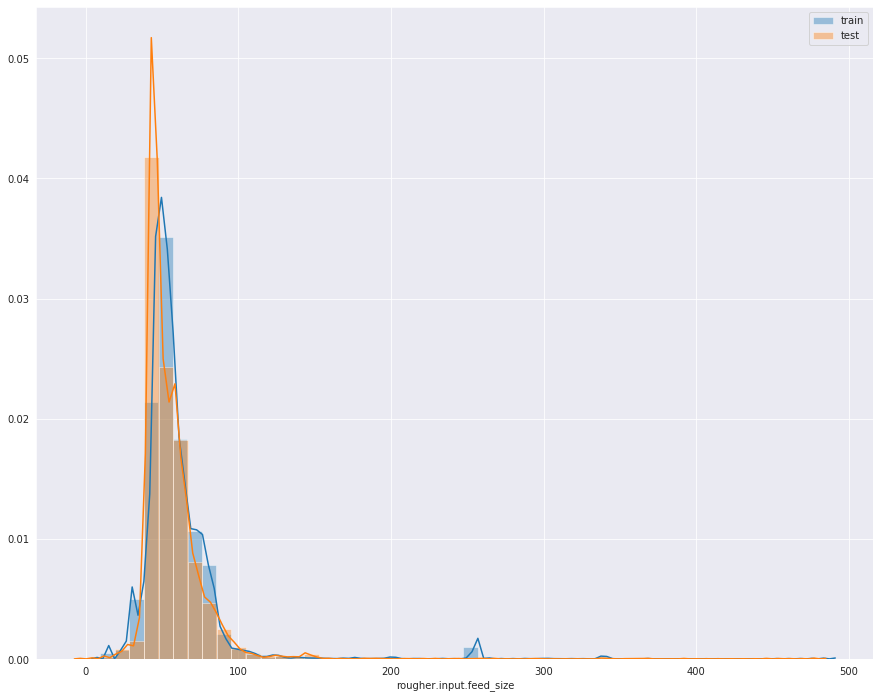

In [19]:
plt.figure(figsize=(15,12))
sns.distplot(df_train['rougher.input.feed_size'], label='train')
sns.distplot(df_test['rougher.input.feed_size'], label='test')
plt.legend();

In [20]:
pd.DataFrame({'train':df_train['rougher.input.feed_size'],
              'test':df_test['rougher.input.feed_size']}).describe()

,train,test
count,16284.000000,5856.000000
mean,60.301532,55.898866
std,30.579265,22.707969
min,9.659576,0.046369
25%,47.575082,43.852884
50%,54.166815,49.964796
75%,65.307309,61.628003
max,484.967466,477.445473


Распределения размеров гранул на обучающей и тестовой выборках схожи между собой. Они характеризуются узким длинным правым хвостом. Аномально высокие значения присутствуют как в обучающей, так и в тестовой выборках. Для лучшего обучения модели удалим аномально высокие значения из тестовой выборки.

In [21]:
max_value = (df_train['rougher.input.feed_size'].quantile(q=0.75) + 
                  1.5* (df_train['rougher.input.feed_size'].quantile(q=0.75) -
                        df_train['rougher.input.feed_size'].quantile(q=0.25)))

In [22]:
df_train = df_train[df_train['rougher.input.feed_size'] <= max_value]
df_train.shape

(15651, 87)

На этом этапе потеряно еще 3-4% данных.

## 2.3 Исследование суммарной концентрации всех веществ на разных стадиях

In [23]:
total_conc_feed_all = (df_full['rougher.input.feed_ag'] + 
                       df_full['rougher.input.feed_pb'] + 
                       df_full['rougher.input.feed_au'] + 
                       df_full['rougher.input.feed_sol'])

total_conc_rougher_all = (df_full['rougher.output.concentrate_ag'] + 
                          df_full['rougher.output.concentrate_pb'] +
                          df_full['rougher.output.concentrate_au'] + 
                          df_full['rougher.output.concentrate_sol'])

total_conc_primary_all = (df_full['primary_cleaner.output.concentrate_ag'] + 
                          df_full['primary_cleaner.output.concentrate_pb'] +
                          df_full['primary_cleaner.output.concentrate_au'] + 
                          df_full['primary_cleaner.output.concentrate_sol'])

total_conc_secondary_all = (df_full['final.output.concentrate_ag'] + 
                            df_full['final.output.concentrate_pb'] +
                            df_full['final.output.concentrate_au'] + 
                            df_full['final.output.concentrate_sol'])

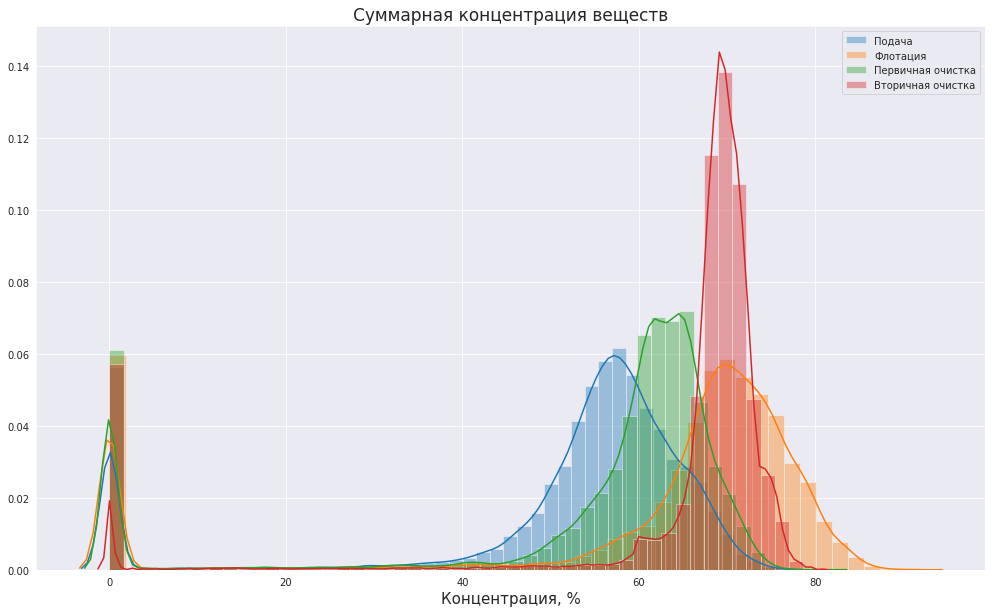

In [24]:
conc_change(total_conc_feed_all, total_conc_rougher_all, total_conc_primary_all, total_conc_secondary_all, 'Суммарная концентрация веществ')

Суммарная концентрация всех веществ после флотации и вторичной очистки имеют схожие средние значения. Распределение концентрации веществ после флотации имеет большую димперсию по сравнению со вторичной очисткой. Среднее первичной очистки меньше остальных двух.

In [25]:
total_conc_feed_metal = (df_full['rougher.input.feed_ag'] + 
                         df_full['rougher.input.feed_pb'] + 
                         df_full['rougher.input.feed_au'])

total_conc_rougher_metal = (df_full['rougher.output.concentrate_ag'] + 
                            df_full['rougher.output.concentrate_pb'] +
                            df_full['rougher.output.concentrate_au'])  

total_conc_primary_metal = (df_full['primary_cleaner.output.concentrate_ag'] + 
                            df_full['primary_cleaner.output.concentrate_pb'] +
                            df_full['primary_cleaner.output.concentrate_au'])

total_conc_secondary_metal = (df_full['final.output.concentrate_ag'] + 
                              df_full['final.output.concentrate_pb'] +
                              df_full['final.output.concentrate_au'])

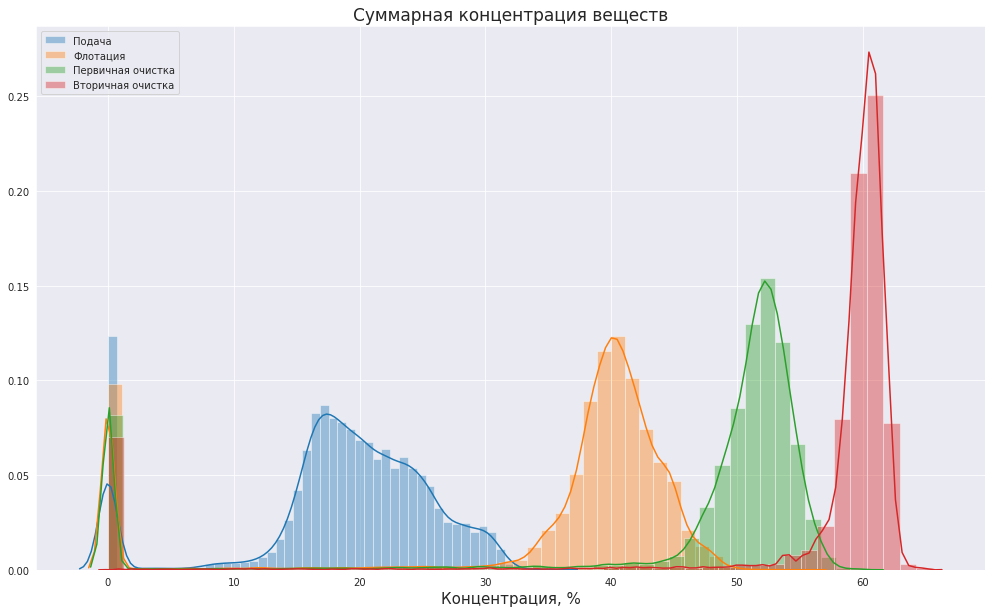

In [26]:
conc_change(total_conc_feed_metal, total_conc_rougher_metal, total_conc_primary_metal, total_conc_secondary_metal, 'Суммарная концентрация веществ')

При сравнении концентрации только металлов на выходе из различных стадий наблюдается более четкая картина. С каждым этапом концентрация металлов растет, а дисперсия уменьшается.

Исключим аномальные значения - нулевые концентрации веществ.

In [27]:
df_full['total_conc_feed_all'] = total_conc_feed_all
df_full['total_conc_rougher_all'] = total_conc_rougher_all
df_full['total_conc_primary_all'] = total_conc_primary_all
df_full['total_conc_secondary_all'] = total_conc_secondary_all

In [28]:
df_full = df_full[(df_full['total_conc_feed_all'] > 5) & 
                  (df_full['total_conc_rougher_all'] > 5) &
                  (df_full['total_conc_primary_all'] > 5) &
                  (df_full['total_conc_secondary_all'] > 5)]

In [29]:
df_train = df_train[((df_train['rougher.input.feed_ag'] + 
                     df_train['rougher.input.feed_pb'] + 
                     df_train['rougher.input.feed_au'] + 
                     df_train['rougher.input.feed_sol']) > 5) & 
                    
                     ((df_train['rougher.output.concentrate_ag'] + 
                      df_train['rougher.output.concentrate_pb'] +
                      df_train['rougher.output.concentrate_au'] + 
                      df_train['rougher.output.concentrate_sol']) > 5) &
                    
                     ((df_train['primary_cleaner.output.concentrate_ag'] + 
                      df_train['primary_cleaner.output.concentrate_pb'] +
                      df_train['primary_cleaner.output.concentrate_au'] + 
                      df_train['primary_cleaner.output.concentrate_sol']) > 5) &

                     ((df_train['final.output.concentrate_ag'] + 
                       df_train['final.output.concentrate_pb'] +
                       df_train['final.output.concentrate_au'] + 
                       df_train['final.output.concentrate_sol']) > 5)]

In [30]:
df_train.shape

(13751, 87)

На этом этапе потеряли 14% данных полной выборки и 18% обучающей. Зато мы не будем предсказывать нулевые концентрации. Посмотрим еще раз на распределение концентраций веществ по стадиям очистки.

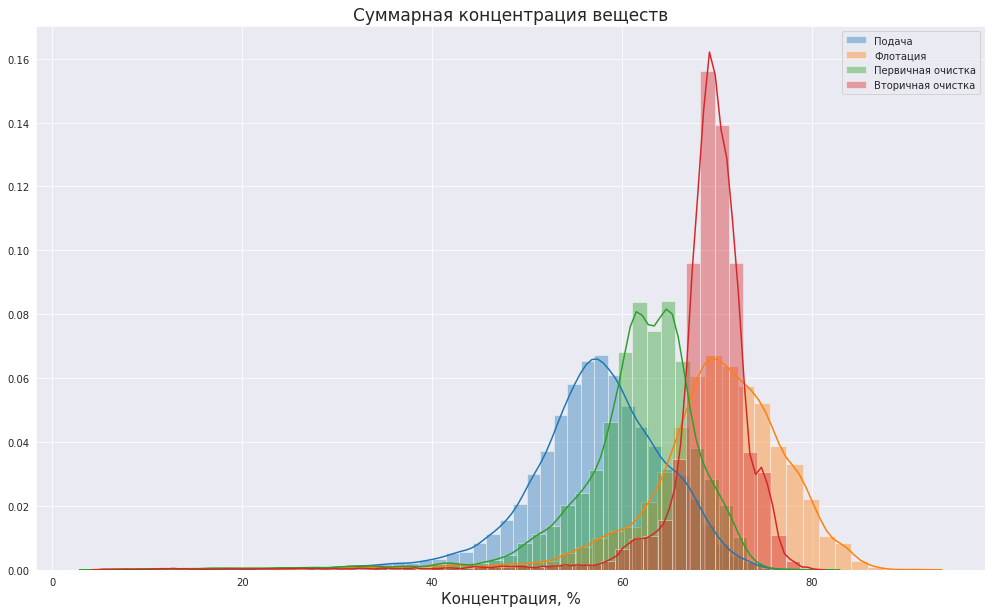

In [31]:
conc_change(df_full['total_conc_feed_all'],
            df_full['total_conc_rougher_all'],
            df_full['total_conc_primary_all'],
            df_full['total_conc_secondary_all'],
            'Суммарная концентрация веществ')

# 3. Модель

## 3.1 Функция для расчета sMAPE

In [32]:
def smape(target, predictions):
    numerator = abs(target - predictions)
    denominator = (abs(target) + abs(predictions)) / 2
    amount = numerator / denominator
    return amount.sum() / len(target) * 100

In [33]:
def final_smape(rougher, final):
    return 0.25 * rougher + 0.75 * final

## 3.2 Обучение моделей и оценка их качества

Нам нужно спрогнозировать две величины: 

- эффективность обогащения чернового концентрата rougher.output.recovery;
- эффективность обогащения финального концентрата final.output.recovery.

Обучим две модели для предсказания каждого из показателей. Если мы будем обучать одну модель для двух показателей, то при предсказании чернового концентрата, модель получит для обучения данные из "будущего", что неприемлемо.

### 3.2.1 Создание обучающих и тестовых выборок

Для обучения моделей нам понадобятся концентрации веществ на входе (input) и показатели процесса (state).

Признаки для моделирования чернового концентрата будут состоять из показателей input и state этапа rougher, а для моделирования финального концентрата - признаки, присутствующие в тестовой выборке.

Целевыми признаками станут признаки output.recovery.

### Обучающая выборка

**Черновой концентрат:**

In [34]:
r = re.compile('(rougher.input.*|rougher.state.*)')
rougher_features_columns_train = [v for v in df_train.columns if r.match(v)]

rougher_features_train = df_train[rougher_features_columns_train]

In [35]:
rougher_target_train = df_train[['rougher.output.recovery']]

**Финальный концентрат:**

In [36]:
final_features_train = df_train[df_test.columns].drop('date', axis=1)

In [37]:
final_target_train = df_train['final.output.recovery']

### Тестовая выборка

**Черновой концентрат:**

In [38]:
r = re.compile('(rougher.*)')
rougher_features_columns_test = [v for v in df_test.columns if r.match(v)]

rougher_features_test = df_test[rougher_features_columns_test]

Целевые признаки подтянем из исходной (полной) таблицы.

In [39]:
rougher_target_test = df_full.loc[df_test.index, 'rougher.output.recovery']

**Финальный концентрат:**

In [40]:
final_features_test = df_test.drop('date', axis=1)

In [41]:
final_target_test = df_full.loc[df_test.index, 'final.output.recovery']

### 3.2.2 Выбор модели

**Черновой концентрат:**

Линейная регрессия:

In [42]:
model_lr_rougher = LinearRegression()

(cross_val_score(model_lr_rougher, rougher_features_train, rougher_target_train, scoring='neg_mean_absolute_error', cv=5)).mean()

-5.342511412619654

Странно: score получился отрицательным. В таком случае будем выбирать модель с максимальным значеним MAE.

Случайный лес:

In [43]:
%%time

df_rf_hparams_rougher_columns = ['max_depth', 'score']
data_rf_hparams_rougher = []
for i in range(1, 20, 1):
    model = RandomForestRegressor(max_depth=i, random_state=12345)
    mae = cross_val_score(model, rougher_features_train, rougher_target_train, scoring='neg_mean_absolute_error',  cv=5).mean()
    data_rf_hparams_rougher.append([i, mae])
    
df_hparams_rougher = pd.DataFrame(data=data_rf_hparams_rougher, columns=df_rf_hparams_rougher_columns)

CPU times: user 2min 20s, sys: 70.4 ms, total: 2min 20s
Wall time: 2min 28s


In [44]:
df_hparams_rougher[df_hparams_rougher['score'] == df_hparams_rougher['score'].max()]

,max_depth,score
4,5,-4.900635


Сохраним значение максимальной глубины при максимальном MAE.

In [45]:
max_depth_rougher =df_hparams_rougher.loc[df_hparams_rougher['score'] == df_hparams_rougher['score'].max(), 'max_depth'].values[0]
max_depth_rougher

5

Лучшую точность показал случайный лес с max depth = 5. Сохраним эту модель в переменной model_rougher.

In [46]:
model_rougher = RandomForestRegressor(max_depth=max_depth_rougher, random_state=12345)
model_rougher.fit(rougher_features_train, rougher_target_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)

**Финальный концентрат:**

Линейная регрессия:

In [47]:
model_lr_final = LinearRegression()

(cross_val_score(model_lr_final, final_features_train, final_target_train, scoring='neg_mean_absolute_error',  cv=5)).mean()

-7.12012406729867

Случайный лес:

In [48]:
%%time

df_rf_hparams_final_columns = ['max_depth', 'score']
data_rf_hparams_final = []
for i in range(1, 20, 1):
    model = RandomForestRegressor(max_depth=i, random_state=12345)
    mae = cross_val_score(model, final_features_train, final_target_train, scoring='neg_mean_absolute_error', cv=5).mean()
    data_rf_hparams_final.append([i, mae])
    
data_rf_hparams_final = pd.DataFrame(data=data_rf_hparams_final, columns=df_rf_hparams_final_columns)

CPU times: user 5min 33s, sys: 132 ms, total: 5min 33s
Wall time: 5min 43s


In [49]:
data_rf_hparams_final[data_rf_hparams_final['score'] == data_rf_hparams_final['score'].max()]

,max_depth,score
3,4,-5.928159


In [50]:
max_depth_final =data_rf_hparams_final.loc[data_rf_hparams_final['score'] == data_rf_hparams_final['score'].max(), 'max_depth'].values[0]

Лучшую точность показал случайный лес с максимальной глубиной 4. Сохраним эту модель в переменной model_final.

In [51]:
model_final = RandomForestRegressor(max_depth=max_depth_final, random_state=12345)
model_final.fit(final_features_train, final_target_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)

### 3.2.3 Тестирование модели

Для тестирования модели применим метрику sMAPE. Для вычисления метрики сохраним предсказания в соответствующих переменных.

In [52]:
predict_rougher = model_rougher.predict(rougher_features_test)
predict_final = model_final.predict(final_features_test)

Вычислим sMAPE для черновой и финальной обработки.

In [53]:
smape_rougher = smape(rougher_target_test, predict_rougher)
smape_final = smape(final_target_test, predict_final)

print('sMAPE черновой обработки: {:.1f}'.format(smape_rougher))
print('sMAPE финальной обработки: {:.1f}'.format(smape_final))

sMAPE черновой обработки: 4.9
sMAPE финальной обработки: 7.7


Вычислим итоговое sMAPE.

In [54]:
final_smape_value = final_smape(smape_rougher, smape_final)
print('Итоговое sMAPE = {:.2f}%'.format(final_smape_value))

Итоговое sMAPE = 6.99%


# Выводы:

- Проведен анализ исходной инфрмации (тестовой, обучающей и исходной выборок).
- В обучающей выборке проверен показатель rougher.output.recovery.
- Проведен анализ изменения концентрации металлов. При анализ концентрации чисто металлов картина предсказуемая: концентрация металлов растет с каждом этапом очистки, а дисперсия концентрации уменьшается. При анализ концентрации совместно с веществом sol, дисперсия также уменьшается от этапа к этапу, а средние концентрации одинаковые после флотации и финальной очистке, а при первичной очистке средняя концентрация ниже. Это может быть связано с непостоянством состава sol или особенностями измерения его концентрации.
- На обучающей выборке протестировано несколько моделей с использованием кросс-валидации (линейная регрессии и случайный лес с различной максимальной глубиной).
- Наилучшие метрики показали модели случайного леса.
- Из предоставленных выборок удалены околонулевые значения эффективности переработки. Это позволило снизить средние абсолютные ошибки с 30-40 до 5-7.
- Выбранные модели показали итоговую sMAPE 6,99%.